In [1]:
import yfinance as yf
import bt
from btpp.strategy import dual_momentum_strategy, saa_weight_strategy
from btpp.helper import get_start_date_off, get_real_start_trading_date
%matplotlib inline

#########################################
# Code For Dual Momentum Strategy(DM)
#########################################

In [2]:
#########################################
portfolios = [
    {
        "name": "SPY/TLT",
        "in_market": ["SPY"],
        "out_market": ["TLT"]
    },
    {
        "name": "QQQ/TLT",
        "in_market": ["QQQ"],
        "out_market": ["TLT"]
    },
    {
        "name": "VWO/TLT",
        "in_market": ["VWO"],
        "out_market": ["TLT"]
    },
    {
        "name": "SPY/TIP",
        "in_market": ["SPY"],
        "out_market": ["TIP"]
    },
    {
        "name": "QQQ/TIP",
        "in_market": ["QQQ"],
        "out_market": ["TIP"]
    },
    {
        "name": "VWO/TIP",
        "in_market": ["VWO"],
        "out_market": ["TIP"]
    },
]

benchmarks = [
    {
        "name": "SPY",
        "weight": {"SPY": 1}
    },
    {
        "name": "QQQ",
        "weight": {"QQQ": 1}
    },
    {
        "name": "VWO",
        "weight": {"VWO": 1}
    },
]

lookbacks = [1, 3, 6]  # Month
lookback_weights = [1, 1, 1]  # Ratio
# lookback_weights = [1, 1, 1]  # Ratio

start_trading_date = "2000-01-01"
end_trading_date = "2021-12-12"
#########################################

In [3]:
tickers_in_market = sum([p["in_market"] for p in portfolios], [])
tickers_out_market = sum([p["out_market"] for p in portfolios], [])
tickers_benchmark = sum([list(it["weight"].keys()) for it in benchmarks], [])

tickers_all = list(
    set(tickers_in_market + tickers_out_market + tickers_benchmark))
print("# All Tickers:")
print(tickers_all)

# All Tickers:
['TLT', 'SPY', 'VWO', 'QQQ', 'TIP']


In [4]:
# Momentum 계산을 위해 6개월 전 데이터부터 가져옴
month_offset = max(lookbacks)
start_date_off = get_start_date_off(
    start_trading_date, month_offset=month_offset)
print(start_date_off)

1999-06-29


In [5]:
# d = bt.get(["spy", "agg"], start="2010-01-01")
# 'Adj Close'를 이용하여 가격 조정
_d = yf.download(tickers_all, start=start_date_off, end=end_trading_date)
d = _d['Adj Close'].dropna()
print(d.head())

[*********************100%***********************]  5 of 5 completed
                  QQQ        SPY        TIP        TLT        VWO
Date                                                             
2005-03-10  32.720127  86.303635  61.797874  52.049641  16.241999
2005-03-11  32.414890  85.698563  61.532917  51.669857  16.222565
2005-03-14  32.563160  86.232430  61.650677  51.979553  16.125431
2005-03-15  32.301521  85.520607  61.568169  51.652363  15.775720
2005-03-16  31.935247  84.794540  61.797874  51.967876  15.639720


In [6]:
# 데이터는 모멘텀 계산을 위해 6개월 이전부터 가져왔지만, 백테스트는 지정한 일자부터 시작함
first_date_of_data = d.index[0].date().isoformat()
real_start_trading_date = get_real_start_trading_date(
    first_date_of_data, month_offset=month_offset)
print("# Firtst Date of Data: ", end="")
print(first_date_of_data)
print("# Real Start Trading Date: ", end="")
print(real_start_trading_date)

# Firtst Date of Data: 2005-03-10
# Real Start Trading Date: 2005-09-12


In [7]:
benchmark_strategys = [saa_weight_strategy(pf["name"], assets_with_weight=pf["weight"],
                                           run_term="monthly", start_trading_date=real_start_trading_date) for pf in benchmarks]
benchmark_tests = [bt.Backtest(s, d) for s in benchmark_strategys]

In [8]:
# 종목을 바꾸어가며 듀얼 모멘텀 테스트
strategys = [
    dual_momentum_strategy(
        pf["name"],
        n=1,
        alternative_n=1,
        lookbacks=lookbacks,
        lookback_weights=lookback_weights,
        assets=pf["in_market"],
        alternative_assets=pf["out_market"],
        all_or_none=False,
        start_trading_date=real_start_trading_date
    ) for pf in portfolios
]

tests = [bt.Backtest(s, d) for s in strategys]

In [9]:
# res = bt.run(*benchmark_tests, *tests)
res = bt.run(*benchmark_tests, *tests)

SPY:2005-10-03 00:00:00. Value:1000000, Price:100.0000
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 1}}
SPY:2005-11-01 00:00:00. Value:982790, Price:98.2790
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 1}}
SPY:2005-12-01 00:00:00. Value:1033359, Price:103.3359
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 1}}
SPY:2006-01-03 00:00:00. Value:1038918, Price:103.8918
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 1}}
SPY:2006-02-01 00:00:00. Value:1052775, Price:105.2775
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 1}}
SPY:2006-03-01 00:00:00. Value:1060811, Price:106.0811
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 1}}
SPY:2006-04-03 00:00:00. Value:1067992, Price:106.7992
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], 'weights': {'SPY': 1}}
SPY:2006-05-01 00:00:00. Value:1073508, Price:107.3508
{'selected': ['QQQ', 'SPY', 'TIP', 'TLT', 'VWO'], '

In [10]:
res.display()

Stat                 SPY         QQQ         VWO         SPY/TLT     QQQ/TLT     VWO/TLT     SPY/TIP     QQQ/TIP     VWO/TIP
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2005-03-09  2005-03-09  2005-03-09  2005-03-09  2005-03-09  2005-03-09  2005-03-09  2005-03-09  2005-03-09
End                  2021-12-10  2021-12-10  2021-12-10  2021-12-10  2021-12-10  2021-12-10  2021-12-10  2021-12-10  2021-12-10
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         427.05%     1047.50%    165.10%     378.99%     793.71%     240.99%     330.81%     536.15%     136.53%
Daily Sharpe         0.61        0.80        0.35        0.68        0.82        0.46        0.69        0.74        0.37
Daily Sortino        0.94        1.26        0.56        1.06        1.27        0.73        1.05        1.12        0.5

<AxesSubplot:title={'center':'Equity Progression'}>

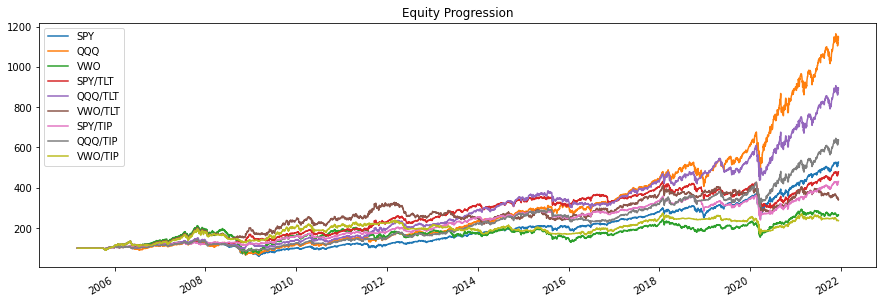

In [11]:
res.plot()

In [12]:
# res.prices

In [13]:
# res.stats